In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dist_s1_enumerator import *
from shapely.geometry import Point
from datetime import datetime, timedelta
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
from pathlib import Path

# Provide AOI

In [3]:
# Over Los Padres National Forest, CA
point = Point(-120.0048, 34.8923)
df_aoi = gpd.GeoDataFrame(geometry=[point], crs=CRS.from_epsg(4326))

# Get Overlapping Tiles

Can be point or polygon.

In [4]:
df_mgrs_tiles = get_mgrs_tiles_overlapping_geometry(point)

## Visualize Overlapping Tiles and AOI

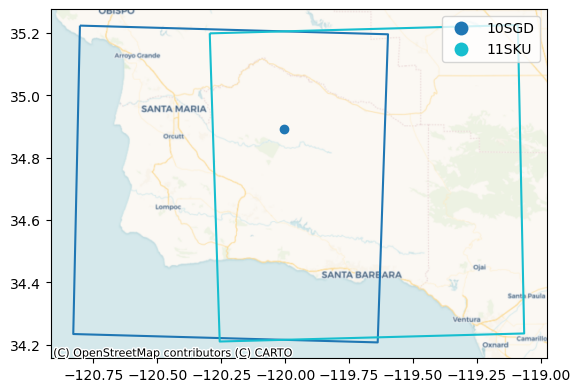

In [5]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.geometry = df_mgrs_tiles_plot.geometry.boundary
df_mgrs_tiles_plot.plot(column='mgrs_tile_id', categorical=True, legend=True, ax=ax)
df_aoi.plot(ax=ax)
ctx.add_basemap(ax,
                crs=df_mgrs_tiles.crs.to_string(),
                source=ctx.providers.CartoDB.Voyager
                )

# Visualize Overlapping Passes

In [6]:
MGRS_TILE = '10SGD'

In [7]:
df_mgrs_burst_luts = get_lut_by_mgrs_tile_ids([MGRS_TILE])
df_mgrs_burst_luts.head()

,mgrs_tile_id,jpl_burst_id,orbit_pass,track_number,acq_group_id_within_mgrs_tile,area_per_acq_group_km2,n_bursts_per_acq_group
0,10SGD,T035-073228-IW3,ASCENDING,35,0,7127,7
1,10SGD,T035-073229-IW3,ASCENDING,35,0,7127,7
2,10SGD,T035-073230-IW3,ASCENDING,35,0,7127,7
3,10SGD,T035-073231-IW3,ASCENDING,35,0,7127,7
4,10SGD,T035-073232-IW3,ASCENDING,35,0,7127,7


In [8]:
df_bursts = get_burst_table_from_mgrs_tiles([MGRS_TILE])
df_bursts.head()

,jpl_burst_id,geometry,track_number,acq_group_id_within_mgrs_tile,mgrs_tile_id
0,T035-073228-IW3,"POLYGON ((-121.08528 34.05287, -120.22744 34.1...",35,0,10SGD
1,T035-073229-IW3,"POLYGON ((-121.11788 34.21917, -120.25912 34.3...",35,0,10SGD
2,T035-073230-IW3,"POLYGON ((-121.15285 34.38514, -120.29232 34.5...",35,0,10SGD
3,T035-073231-IW3,"POLYGON ((-121.18785 34.55111, -120.32556 34.6...",35,0,10SGD
4,T035-073232-IW3,"POLYGON ((-121.22291 34.71708, -120.35882 34.8...",35,0,10SGD


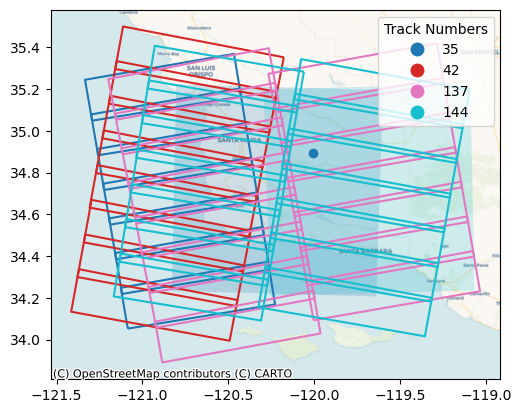

In [9]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.plot(column='mgrs_tile_id', categorical=True, ax=ax, alpha=.2)
df_aoi.plot(ax=ax)
df_bursts_plot = df_bursts.copy()
df_bursts_plot.geometry = df_bursts_plot.geometry.boundary
df_bursts_plot.plot(column='track_number', categorical=True, ax=ax, legend=True)
leg = ax.get_legend()
leg.set_title('Track Numbers')
ctx.add_basemap(ax,
                crs=df_mgrs_tiles.crs.to_string(),
                source=ctx.providers.CartoDB.Voyager
                )

## Visualize specific group

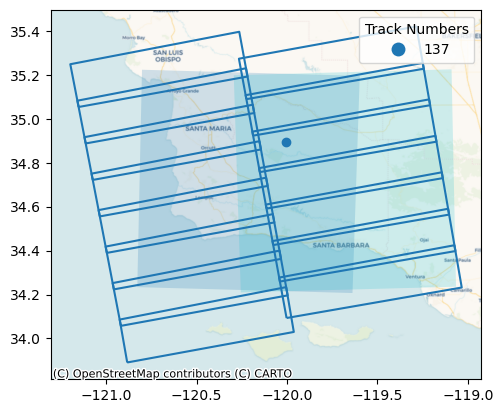

In [10]:
TRACK_NUMBERS = [137]

fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.plot(column='mgrs_tile_id', categorical=True, ax=ax, alpha=.2)
df_aoi.plot(ax=ax)
df_bursts_plot = df_bursts.copy()
df_bursts_plot.geometry = df_bursts_plot.geometry.boundary
df_bursts_plot = df_bursts_plot[df_bursts_plot.track_number.isin(TRACK_NUMBERS)].reset_index(drop=True)
df_bursts_plot.plot(column='track_number', categorical=True, ax=ax, legend=True)
leg = ax.get_legend()
leg.set_title('Track Numbers')
ctx.add_basemap(ax,
                crs=df_mgrs_tiles.crs.to_string(),
                source=ctx.providers.CartoDB.Voyager
                )

# Get Latest set of RTC-S1 Data (Post-images)

This could be seen as the post-image set.

In [12]:
today = datetime.today()
df_rtc_post = get_rtc_s1_temporal_group_metadata([MGRS_TILE], 
                                                 track_numbers=TRACK_NUMBERS,
                                                 start_acq_dt= today, 
                                                 stop_acq_dt= today - timedelta(days=30),
                                                 max_variation_seconds=60,
                                                 n_images_per_burst = 1)
df_rtc_post.head()

,opera_id,jpl_burst_id,acq_dt,polarization,url_vh,url_vv,track_number,geometry,acq_date,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token
0,OPERA_L2_RTC-S1_T137-292318-IW1_20241127T01590...,T137-292318-IW1,2024-11-27 01:59:00+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.88201 33.89008, -119.86899 34.0...",2024-11-27 00:00:00+00:00,10SGD,2,137
1,OPERA_L2_RTC-S1_T137-292318-IW2_20241127T01590...,T137-292318-IW2,2024-11-27 01:59:01+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.00205 34.08588, -118.9574 34.23...",2024-11-27 00:00:00+00:00,10SGD,2,137
2,OPERA_L2_RTC-S1_T137-292319-IW1_20241127T01590...,T137-292319-IW1,2024-11-27 01:59:03+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.92073 34.05617, -119.90835 34.2...",2024-11-27 00:00:00+00:00,10SGD,2,137
3,OPERA_L2_RTC-S1_T137-292319-IW2_20241127T01590...,T137-292319-IW2,2024-11-27 01:59:04+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.039 34.25219, -118.99203 34.406...",2024-11-27 00:00:00+00:00,10SGD,2,137
4,OPERA_L2_RTC-S1_T137-292320-IW1_20241127T01590...,T137-292320-IW1,2024-11-27 01:59:06+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.95958 34.22249, -119.9451 34.37...",2024-11-27 00:00:00+00:00,10SGD,2,137


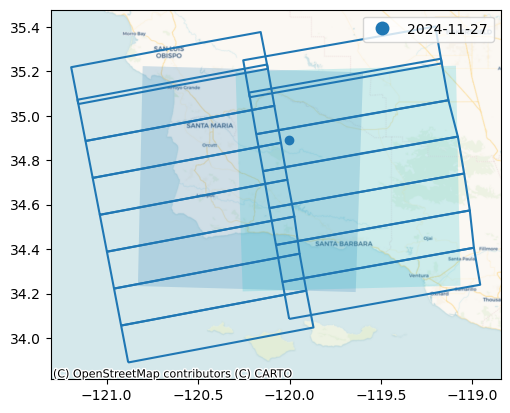

In [14]:

fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.plot(column='mgrs_tile_id', categorical=True, ax=ax, alpha=.2)
df_aoi.plot(ax=ax)
df_rtc_plot = df_rtc_post.copy()
df_rtc_plot.geometry = df_rtc_plot.geometry.boundary
df_rtc_plot['acq_date_str'] = df_rtc_plot['acq_date'].dt.date.astype(str)
df_rtc_plot.plot(column='acq_date_str', categorical=True, ax=ax, legend=True)
ctx.add_basemap(ax,
                crs=df_mgrs_tiles.crs.to_string(),
                source=ctx.providers.CartoDB.Voyager
                )

## Few minor notes
1. The geometries from our burst table differ from those collected from the DAAC (note the overlap)
2. In some cases, the burst ids collected from the latest pass will equal the total fixed bursts requests. In some cases, the actual data from the latest pass will be *less* than the requested bursts. This is due to S1 availability.

# Get historical baseline (Pre-images)

In [18]:
post_dt = df_rtc_post.acq_dt.min()
df_rtc_pre = get_rtc_s1_temporal_group_metadata([MGRS_TILE],
                                                TRACK_NUMBERS,
                                                 stop_acq_dt= post_dt - timedelta(days=1), 
                                                 start_acq_dt= post_dt - timedelta(days=366),
                                                 n_images_per_burst = 10)

In [19]:
df_rtc_pre.head()

,opera_id,jpl_burst_id,acq_dt,polarization,url_vh,url_vv,track_number,geometry,acq_date,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token
0,OPERA_L2_RTC-S1_T137-292318-IW1_20240730T01590...,T137-292318-IW1,2024-07-30 01:59:00+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.88131 33.88936, -119.86846 34.0...",2024-07-30 00:00:00+00:00,10SGD,2,137
1,OPERA_L2_RTC-S1_T137-292318-IW1_20240811T01590...,T137-292318-IW1,2024-08-11 01:59:00+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.88224 33.88919, -119.86935 34.0...",2024-08-11 00:00:00+00:00,10SGD,2,137
2,OPERA_L2_RTC-S1_T137-292318-IW1_20240823T01590...,T137-292318-IW1,2024-08-23 01:59:00+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.88231 33.88907, -119.86942 34.0...",2024-08-23 00:00:00+00:00,10SGD,2,137
3,OPERA_L2_RTC-S1_T137-292318-IW1_20240904T01590...,T137-292318-IW1,2024-09-04 01:59:00+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.88173 33.8894, -119.86874 34.04...",2024-09-04 00:00:00+00:00,10SGD,2,137
4,OPERA_L2_RTC-S1_T137-292318-IW1_20240916T01590...,T137-292318-IW1,2024-09-16 01:59:01+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.88408 33.88926, -119.87119 34.0...",2024-09-16 00:00:00+00:00,10SGD,2,137


In [20]:
df_rtc_pre_agg = agg_rtc_metadata_by_burst_id(df_rtc_pre)
df_rtc_pre_agg.head()

,jpl_burst_id,count,earliest_acq_date,latest_acq_date
0,T137-292318-IW1,10,2024-07-30 01:59:00+00:00,2024-11-15 01:59:01+00:00
1,T137-292318-IW2,10,2024-07-30 01:59:01+00:00,2024-11-15 01:59:02+00:00
2,T137-292319-IW1,10,2024-07-30 01:59:03+00:00,2024-11-15 01:59:04+00:00
3,T137-292319-IW2,10,2024-07-30 01:59:04+00:00,2024-11-15 01:59:05+00:00
4,T137-292320-IW1,10,2024-07-30 01:59:05+00:00,2024-11-15 01:59:07+00:00


# Localizing Inputs

In [21]:
from dist_s1_enumerator.rtc_s1_io import localize_rtc_s1_ts, generate_rtc_s1_local_paths

In [22]:
out_dir = Path('out')
out_dir.mkdir(exist_ok=True, parents=True)

In [23]:
df_rtc_pre_loc = localize_rtc_s1_ts(df_rtc_pre, out_dir, max_workers=5)

100%|████████████████████████████████████| 300/300 [00:00<00:00, 453274.93it/s]


In [24]:
df_rtc_post_loc = localize_rtc_s1_ts(df_rtc_post, out_dir, max_workers=5)

100%|██████████████████████████████████████| 30/30 [00:00<00:00, 446202.55it/s]


In [25]:
df_rtc_post_loc.head()

,opera_id,jpl_burst_id,acq_dt,polarization,url_vh,url_vv,track_number,geometry,acq_date,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token,loc_path_vv,loc_path_vh
0,OPERA_L2_RTC-S1_T137-292318-IW1_20241127T01590...,T137-292318-IW1,2024-11-27 01:59:00+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.88201 33.89008, -119.86899 34.0...",2024-11-27 00:00:00+00:00,10SGD,2,137,out/10SGD/137/2024-11-27/OPERA_L2_RTC-S1_T137-...,out/10SGD/137/2024-11-27/OPERA_L2_RTC-S1_T137-...
1,OPERA_L2_RTC-S1_T137-292318-IW2_20241127T01590...,T137-292318-IW2,2024-11-27 01:59:01+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.00205 34.08588, -118.9574 34.23...",2024-11-27 00:00:00+00:00,10SGD,2,137,out/10SGD/137/2024-11-27/OPERA_L2_RTC-S1_T137-...,out/10SGD/137/2024-11-27/OPERA_L2_RTC-S1_T137-...
2,OPERA_L2_RTC-S1_T137-292319-IW1_20241127T01590...,T137-292319-IW1,2024-11-27 01:59:03+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.92073 34.05617, -119.90835 34.2...",2024-11-27 00:00:00+00:00,10SGD,2,137,out/10SGD/137/2024-11-27/OPERA_L2_RTC-S1_T137-...,out/10SGD/137/2024-11-27/OPERA_L2_RTC-S1_T137-...
3,OPERA_L2_RTC-S1_T137-292319-IW2_20241127T01590...,T137-292319-IW2,2024-11-27 01:59:04+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.039 34.25219, -118.99203 34.406...",2024-11-27 00:00:00+00:00,10SGD,2,137,out/10SGD/137/2024-11-27/OPERA_L2_RTC-S1_T137-...,out/10SGD/137/2024-11-27/OPERA_L2_RTC-S1_T137-...
4,OPERA_L2_RTC-S1_T137-292320-IW1_20241127T01590...,T137-292320-IW1,2024-11-27 01:59:06+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.95958 34.22249, -119.9451 34.37...",2024-11-27 00:00:00+00:00,10SGD,2,137,out/10SGD/137/2024-11-27/OPERA_L2_RTC-S1_T137-...,out/10SGD/137/2024-11-27/OPERA_L2_RTC-S1_T137-...


In [26]:
date_tokens = df_rtc_post_loc['acq_date'].dt.date.unique().astype(str).tolist()
date_tokens

['2024-11-27']

In [27]:
track_tokens = df_rtc_post_loc['track_token'].unique().tolist()
track_tokens

['137']

In [28]:
df_rtc_pre_loc.to_parquet(f'{MGRS_TILE}__{track_tokens[0]}__{date_tokens[0]}__pre.parquet')
df_rtc_post_loc.to_parquet(f'{MGRS_TILE}__{track_tokens[0]}__{date_tokens[0]}__post.parquet')